In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import yaml

from scipy.stats import binned_statistic_2d
# import shap

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [3]:
MODELS = [os.path.join('analysis_checkpoints_v7.0', m) for m in os.listdir(get_path('results', 'evaluation', 'analysis_checkpoints_v7.0'))]

In [4]:
MODELS_DESCRIPTION = {k: k.replace('v7.0_', '') for k in MODELS}

In [5]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool 15',
}

In [6]:
configs = {}

for model in MODELS:
    with open(get_path(f'configs/v7.0/evaluation.yaml'), 'r') as f:
        configs[model] = yaml.safe_load(f)

In [7]:
test_sets = {model: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{model}'))] for model in MODELS}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [8]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

In [9]:
remove_invalid = []

for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Loading {model} results'):
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            # keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            # keys_to_remove.extend(['x', 'y'])

            # for k in keys_to_remove:
            #     del test_set_results['data'][k]

Loading analysis_checkpoints_v7.0/v7.0_checkpoint-100000 results: 100%|██████████| 6/6 [00:27<00:00,  4.66s/it]
Loading analysis_checkpoints_v7.0/v7.0_checkpoint-900000 results: 100%|██████████| 2/2 [00:11<00:00,  5.56s/it]
Loading analysis_checkpoints_v7.0/v7.0_checkpoint-1000000 results: 100%|██████████| 6/6 [00:29<00:00,  4.94s/it]
Loading analysis_checkpoints_v7.0/v7.0_checkpoint-800000 results: 100%|██████████| 2/2 [00:08<00:00,  4.48s/it]
Loading analysis_checkpoints_v7.0/v7.0_checkpoint-600000 results: 100%|██████████| 6/6 [00:25<00:00,  4.27s/it]
Loading analysis_checkpoints_v7.0/v7.0_checkpoint-700000 results: 100%|██████████| 6/6 [00:29<00:00,  4.88s/it]
Loading analysis_checkpoints_v7.0/v7.0_checkpoint-400000 results: 100%|██████████| 6/6 [00:33<00:00,  5.61s/it]
Loading analysis_checkpoints_v7.0/v7.0_checkpoint-300000 results: 100%|██████████| 2/2 [00:09<00:00,  4.88s/it]
Loading analysis_checkpoints_v7.0/v7.0_checkpoint-500000 results: 100%|██████████| 6/6 [00:31<00:00,  5

In [10]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            results[model][test_set]['data']['wall_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))
            results[model][test_set]['data']['sys_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))

100%|██████████| 6/6 [00:00<00:00, 2503.81it/s]


In [11]:
# Replace 'beam_val_' with 'val_beam' in columns where 'beam_val_' is present
for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        columns_before = set(data.keys())
        changed_columns = []
        for k in columns_before:
            if 'beam_val_' in k:
                data[k.replace('beam_val_', 'val_beam_')] = data[k]
                changed_columns.append(k)

        for k in changed_columns:
            del data[k]

100%|██████████| 6/6 [00:00<00:00, 9411.30it/s]


In [12]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])
        
        for j in range(beam_width):
            results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) for i in range(len(data[f'free_beam_{j + 1}']))])

            if f'residuals_beam_{j + 1}' not in data:
                continue
            results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
        
        if '_beam_1' not in data:
            continue

        max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(beam_width))

        for j in range(beam_width):
            padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
            data[f'_beam_{j + 1}'] = np.array(padded_beam)

  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_7196/343701655.py:14: RuntimeWarning: All-NaN slice encountered
  results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
100%|██████████| 6/6 [00:00<00:00,  8.59it/s]


In [13]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        valid = True
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'residuals' in k and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 6/6 [00:00<00:00, 29.89it/s]


In [14]:
# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        print(f'Processing {model} {test_set}')
        for maybe_val in ['', '_val']:
            test_set_results['data'][f'is_finite{maybe_val}'] = np.array([np.isfinite(r2) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'FVU-eps_accuracy{maybe_val}'] = np.array([(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu{maybe_val}'] = np.array([1 - r2 for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])
            test_set_results['data'][f'log_fvu{maybe_val}'] = np.array([max(1 - r2, np.finfo(np.float32).eps) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'] = np.copy(test_set_results['data'][f'fvu{maybe_val}'])
            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'][test_set_results['data'][f'FVU-eps_accuracy{maybe_val}']] = np.nan

            test_set_results['data'][f'log_fvu_not_epsilon{maybe_val}'] = np.array([np.log10(fvu) for fvu in test_set_results['data'][f'fvu_not_epsilon{maybe_val}']])

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = [np.log10(ppl) for ppl in test_set_results['data']['perplexity']]
        else:
            test_set_results['data']['log_ppl'] = [np.nan] * len(test_set_results['data']['r2_best_beam'])

Processing analysis_checkpoints_v7.0/v7.0_checkpoint-100000 train
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-100000 val
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-100000 feynman
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-100000 soose_nc
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-100000 nguyen
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-100000 pool_15
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-900000 feynman
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-900000 soose_nc
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-1000000 train
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-1000000 val
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-1000000 feynman
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-1000000 soose_nc
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-1000000 nguyen
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-1000000 pool_15
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-

In [15]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'y_noisy', 'x_val', 'y_val', 'y_noisy_val', 'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c for i in range(1, 1024))}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
compare_columns

{'FVU-eps_accuracy',
 'FVU-eps_accuracy_val',
 'L_inf_best_beam',
 'NSRTS_accuracy_close_best_beam',
 'NSRTS_accuracy_close_val_best_beam',
 'NSRTS_accuracy_r2_best_beam',
 'NSRTS_accuracy_r2_val_best_beam',
 'accuracy_best_beam',
 'beam_search_time',
 'best_beam',
 'bleu_best_beam',
 'edit_distance_best_beam',
 'f1_score_best_beam',
 'fvu',
 'fvu_not_epsilon',
 'fvu_not_epsilon_val',
 'fvu_val',
 'is_finite',
 'is_finite_val',
 'length_best_beam',
 'length_target',
 'log_fvu',
 'log_fvu_not_epsilon',
 'log_fvu_not_epsilon_val',
 'log_fvu_val',
 'log_ppl',
 'meteor_best_beam',
 'mse_best_beam',
 'mse_val_best_beam',
 'perplexity',
 'precision_best_beam',
 'r2_best_beam',
 'r2_val_best_beam',
 'recall_best_beam',
 'reciprocal_rank',
 'refiner_time_best_beam',
 'rouge1_fmeasure_best_beam',
 'rouge1_precision_best_beam',
 'rouge1_recall_best_beam',
 'rouge2_fmeasure_best_beam',
 'rouge2_precision_best_beam',
 'rouge2_recall_best_beam',
 'rougeL_fmeasure_best_beam',
 'rougeL_precision_best

In [16]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [17]:
compare_columns_defaults = {
    'FVU-eps_accuracy': 0,
    'perplexity': np.inf,
    'log_ppl': np.inf,
    'precision_best_beam': 0,
    'recall_best_beam': 0,
    'L_inf_best_beam': np.inf,
    'NSRTS_accuracy_close_best_beam': 0,
    'NSRTS_accuracy_r2_best_beam': 0,
    'NSRTS_accuracy_close_val_best_beam': 0,
    'NSRTS_accuracy_r2_val_best_beam': 0,
    'accuracy_best_beam': 0,
    'bleu_best_beam': 0,
    'edit_distance_best_beam': np.inf,
    'f1_score_best_beam': 0,
    'fvu': np.inf,
    'log_fvu': np.inf,
    'fvu_not_epsilon': np.inf,
    'log_fvu_not_epsilon': np.inf,
    'log_ppl': np.inf,
    'meteor_best_beam': 0,
    'mse_best_beam': np.inf,
    'mse_val_best_beam': np.inf,
    'perplexity': np.inf,
    'precision_best_beam': 0,
    'r2_best_beam': -np.inf,
    'r2_val_best_beam': -np.inf,
    'recall_best_beam': 0,
    'reciprocal_rank': 0,
    'rouge1_fmeasure_best_beam': 0,
    'rouge1_precision_best_beam': 0,
    'rouge1_recall_best_beam': 0,
    'rouge2_fmeasure_best_beam': 0,
    'rouge2_precision_best_beam': 0,
    'rouge2_recall_best_beam': 0,
    'rougeL_fmeasure_best_beam': 0,
    'rougeL_precision_best_beam': 0,
    'rougeL_recall_best_beam': 0,
    'structural_accuracy_best_beam': 0,
    'tree_edit_distance_best_beam': np.inf,
    'wall_time': np.inf,
    'sys_time': np.inf,
    'is_finite': 0,
}

In [18]:
from functools import partial

In [19]:
def naninfmean(x):
    return np.nanmean(np.array(x)[np.isfinite(x)])

# Per Dataset

In [20]:
summaries = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                summaries[model][test_set][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                summaries[model][test_set][column] = {k: (np.nan, ) * 3 for k in sub_metrics}

            if metrics is None:
                metrics = summaries[model][test_set][column].keys()

analysis_checkpoints_v7.0/v7.0_checkpoint-100000 train:  29%|██▊       | 14/49 [00:01<00:04,  7.15it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_checkpoints_v7.0/v7.0_checkpoint-100000 train: 100%|██████████| 49/49 [00:06<00:00,  7.27it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-100000 val: 100%|██████████| 49/49 [00:06<00:00,  7.81it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-100000 feynman: 100%|██████████| 49/49 [00:05<00:00,  9.07it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-100000 soose_nc: 100%|██████████| 49/49 [00:05<00:00,  9.26it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-100000 nguyen: 100%|██████████| 49/49 [00:05<00:00,  9.32it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-100000 pool_15: 100%|██████████| 49/49 [00:05<00:00,  9.43it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-900000 feynman: 100%|██████████| 

In [21]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

summary_tables = {
    column: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    test_set: summaries[model][test_set][column][metric][k]
                    for test_set in summaries[model].keys()}
                    for model in summaries.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for column in compare_columns}

#### Validity

In [22]:
m = 'is_finite'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"nan (nan, nan)","nan (nan, nan)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"nan (nan, nan)","nan (nan, nan)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"0.999 (0.997, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"1.0 (1.0, 1.0)","0.999 (0.997, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_checkpoints_v7.0/v7.0_checkpoint-300000,"nan (nan, nan)","nan (nan, nan)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-500000,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_checkpoints_v7.0/v7.0_checkpoint-200000,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"


#### Recovery Rate

In [23]:
m = 'NSRTS_accuracy_close_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"0.484 (0.454, 0.515)","0.499 (0.467, 0.531)","0.732 (0.706, 0.759)","0.417 (0.386, 0.447)","0.52 (0.491, 0.552)","0.467 (0.436, 0.495)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"nan (nan, nan)","nan (nan, nan)","0.854 (0.832, 0.875)","0.794 (0.767, 0.82)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"0.719 (0.692, 0.748)","0.726 (0.698, 0.756)","0.867 (0.845, 0.889)","0.825 (0.803, 0.849)","0.849 (0.827, 0.871)","0.609 (0.577, 0.64)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"nan (nan, nan)","nan (nan, nan)","0.869 (0.848, 0.89)","0.79 (0.764, 0.813)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"0.655 (0.625, 0.684)","0.698 (0.667, 0.724)","0.837 (0.813, 0.86)","0.75 (0.722, 0.774)","0.855 (0.832, 0.876)","0.584 (0.553, 0.616)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"0.68 (0.648, 0.708)","0.707 (0.677, 0.736)","0.851 (0.826, 0.873)","0.765 (0.74, 0.793)","0.842 (0.82, 0.864)","0.605 (0.575, 0.635)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"0.634 (0.605, 0.663)","0.646 (0.617, 0.675)","0.831 (0.809, 0.852)","0.717 (0.688, 0.744)","0.778 (0.753, 0.804)","0.562 (0.531, 0.595)"
analysis_checkpoints_v7.0/v7.0_checkpoint-300000,"nan (nan, nan)","nan (nan, nan)","0.788 (0.762, 0.812)","0.677 (0.648, 0.705)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-500000,"0.692 (0.665, 0.72)","0.675 (0.647, 0.704)","0.836 (0.812, 0.858)","0.752 (0.726, 0.779)","0.863 (0.84, 0.884)","0.605 (0.576, 0.635)"
analysis_checkpoints_v7.0/v7.0_checkpoint-200000,"0.567 (0.537, 0.601)","0.598 (0.565, 0.627)","0.778 (0.753, 0.803)","0.602 (0.571, 0.631)","0.735 (0.706, 0.762)","0.522 (0.493, 0.55)"


In [24]:
m = 'NSRTS_accuracy_r2_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"0.745 (0.719, 0.772)","0.772 (0.745, 0.798)","0.848 (0.826, 0.869)","0.627 (0.598, 0.655)","0.75 (0.724, 0.777)","0.69 (0.66, 0.717)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"nan (nan, nan)","nan (nan, nan)","0.926 (0.91, 0.941)","0.858 (0.836, 0.877)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"0.876 (0.855, 0.896)","0.888 (0.867, 0.909)","0.946 (0.932, 0.959)","0.878 (0.856, 0.899)","0.983 (0.974, 0.99)","0.802 (0.777, 0.826)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"nan (nan, nan)","nan (nan, nan)","0.937 (0.921, 0.952)","0.866 (0.848, 0.887)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"0.856 (0.834, 0.878)","0.895 (0.876, 0.915)","0.917 (0.899, 0.933)","0.831 (0.808, 0.853)","0.978 (0.969, 0.986)","0.777 (0.752, 0.802)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"0.882 (0.861, 0.901)","0.873 (0.852, 0.894)","0.932 (0.915, 0.947)","0.858 (0.836, 0.878)","0.976 (0.966, 0.985)","0.796 (0.772, 0.82)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"0.834 (0.812, 0.858)","0.861 (0.839, 0.881)","0.907 (0.888, 0.924)","0.817 (0.794, 0.841)","0.968 (0.957, 0.978)","0.762 (0.736, 0.787)"
analysis_checkpoints_v7.0/v7.0_checkpoint-300000,"nan (nan, nan)","nan (nan, nan)","0.896 (0.876, 0.915)","0.793 (0.769, 0.818)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-500000,"0.878 (0.856, 0.897)","0.873 (0.853, 0.893)","0.917 (0.9, 0.934)","0.844 (0.822, 0.866)","0.981 (0.972, 0.989)","0.793 (0.769, 0.817)"
analysis_checkpoints_v7.0/v7.0_checkpoint-200000,"0.817 (0.792, 0.841)","0.838 (0.815, 0.859)","0.878 (0.856, 0.897)","0.744 (0.717, 0.77)","0.902 (0.883, 0.919)","0.711 (0.681, 0.74)"


In [25]:
m = 'FVU-eps_accuracy'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"0.285 (0.257, 0.312)","0.302 (0.275, 0.33)","0.622 (0.592, 0.652)","0.226 (0.2, 0.253)","0.298 (0.269, 0.326)","0.218 (0.192, 0.245)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"nan (nan, nan)","nan (nan, nan)","0.705 (0.674, 0.732)","0.662 (0.632, 0.689)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"0.535 (0.504, 0.567)","0.527 (0.497, 0.559)","0.763 (0.737, 0.789)","0.704 (0.678, 0.732)","0.694 (0.667, 0.721)","0.33 (0.299, 0.36)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"nan (nan, nan)","nan (nan, nan)","0.742 (0.715, 0.767)","0.654 (0.626, 0.682)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"0.457 (0.427, 0.488)","0.519 (0.489, 0.551)","0.711 (0.68, 0.737)","0.599 (0.566, 0.628)","0.677 (0.65, 0.705)","0.304 (0.275, 0.333)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"0.482 (0.451, 0.514)","0.502 (0.468, 0.534)","0.728 (0.699, 0.755)","0.618 (0.588, 0.647)","0.674 (0.645, 0.704)","0.288 (0.259, 0.316)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"0.4 (0.372, 0.431)","0.457 (0.429, 0.486)","0.687 (0.664, 0.718)","0.539 (0.51, 0.571)","0.621 (0.592, 0.65)","0.295 (0.268, 0.325)"
analysis_checkpoints_v7.0/v7.0_checkpoint-300000,"nan (nan, nan)","nan (nan, nan)","0.66 (0.629, 0.689)","0.508 (0.476, 0.541)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-500000,"0.485 (0.454, 0.518)","0.466 (0.438, 0.496)","0.722 (0.694, 0.747)","0.602 (0.572, 0.633)","0.672 (0.644, 0.704)","0.326 (0.299, 0.356)"
analysis_checkpoints_v7.0/v7.0_checkpoint-200000,"0.362 (0.331, 0.391)","0.389 (0.358, 0.418)","0.653 (0.625, 0.683)","0.423 (0.393, 0.452)","0.561 (0.529, 0.59)","0.254 (0.227, 0.281)"


#### Numeric Error

In [26]:
m = 'fvu'
sm = '97.5p'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"1.0 (0.998, 1.037)","0.997 (0.985, 1.0)","1.0 (0.987, 1.024)","1.572 (1.392, 1.67)","0.987 (0.969, 0.993)","0.999 (0.995, 1.0)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"nan (nan, nan)","nan (nan, nan)","0.916 (0.772, 0.961)","1.005 (1.0, 1.205)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"0.994 (0.981, 0.999)","0.982 (0.942, 0.998)","0.787 (0.305, 0.931)","1.01 (1.0, 1.285)","0.016 (0.006, 0.056)","1.0 (0.991, 1.023)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"nan (nan, nan)","nan (nan, nan)","0.851 (0.455, 0.975)","1.033 (1.0, 1.358)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"0.999 (0.986, 1.001)","0.984 (0.903, 0.996)","0.957 (0.794, 0.986)","1.168 (1.01, 1.34)","0.043 (0.019, 0.095)","1.001 (0.998, 1.015)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"0.993 (0.948, 0.999)","0.993 (0.959, 0.999)","0.95 (0.74, 0.974)","1.045 (1.0, 1.207)","0.048 (0.015, 0.102)","1.0 (0.995, 1.001)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"0.999 (0.994, 1.002)","0.993 (0.94, 1.0)","0.952 (0.895, 0.982)","1.203 (1.005, 1.411)","0.078 (0.028, 0.174)","1.0 (0.999, 1.002)"
analysis_checkpoints_v7.0/v7.0_checkpoint-300000,"nan (nan, nan)","nan (nan, nan)","0.973 (0.909, 0.996)","1.177 (1.008, 1.458)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-500000,"0.978 (0.945, 0.998)","0.998 (0.964, 1.001)","0.95 (0.868, 0.989)","1.291 (1.044, 1.559)","0.027 (0.007, 0.057)","1.0 (0.996, 1.001)"
analysis_checkpoints_v7.0/v7.0_checkpoint-200000,"0.992 (0.973, 0.998)","0.995 (0.965, 0.999)","0.989 (0.968, 0.998)","1.155 (1.043, 1.422)","0.962 (0.869, 0.988)","1.001 (1.0, 1.066)"


#### Time

In [27]:
m = 'wall_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"2.149 (2.116, 2.192)","2.067 (2.049, 2.087)","1.996 (1.976, 2.025)","2.109 (2.091, 2.138)","1.964 (1.949, 1.977)","2.198 (2.148, 2.261)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"nan (nan, nan)","nan (nan, nan)","2.061 (2.037, 2.08)","2.049 (2.013, 2.087)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"2.094 (2.069, 2.138)","2.097 (2.069, 2.134)","2.08 (2.062, 2.1)","2.002 (1.988, 2.018)","2.054 (2.023, 2.086)","2.187 (2.143, 2.23)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"nan (nan, nan)","nan (nan, nan)","2.042 (2.013, 2.088)","2.076 (2.038, 2.139)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"2.101 (2.056, 2.135)","2.024 (1.995, 2.063)","2.042 (2.013, 2.084)","2.013 (1.977, 2.059)","2.085 (2.047, 2.127)","2.167 (2.128, 2.208)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"2.072 (2.03, 2.141)","2.118 (2.069, 2.179)","1.991 (1.965, 2.021)","2.018 (1.981, 2.072)","2.038 (1.997, 2.092)","2.175 (2.131, 2.259)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"2.182 (2.121, 2.236)","2.125 (2.077, 2.196)","2.124 (2.091, 2.168)","2.075 (2.04, 2.118)","2.199 (2.169, 2.234)","2.275 (2.212, 2.354)"
analysis_checkpoints_v7.0/v7.0_checkpoint-300000,"nan (nan, nan)","nan (nan, nan)","2.156 (2.115, 2.198)","2.108 (2.061, 2.186)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-500000,"2.101 (2.062, 2.14)","2.06 (2.043, 2.081)","1.978 (1.959, 1.999)","2.048 (2.008, 2.103)","2.01 (1.989, 2.032)","2.365 (2.327, 2.416)"
analysis_checkpoints_v7.0/v7.0_checkpoint-200000,"2.122 (2.083, 2.164)","2.904 (2.859, 2.949)","1.979 (1.963, 2.003)","2.175 (2.116, 2.216)","2.098 (2.065, 2.151)","2.658 (2.564, 2.712)"


In [28]:
m = 'sys_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"2.149 (2.116, 2.192)","2.068 (2.05, 2.088)","1.996 (1.976, 2.025)","2.109 (2.091, 2.136)","1.964 (1.951, 1.977)","2.2 (2.151, 2.265)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"nan (nan, nan)","nan (nan, nan)","2.06 (2.036, 2.08)","2.049 (2.013, 2.086)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"2.094 (2.07, 2.137)","2.097 (2.067, 2.134)","2.08 (2.06, 2.101)","2.003 (1.988, 2.018)","2.053 (2.025, 2.088)","2.185 (2.144, 2.228)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"nan (nan, nan)","nan (nan, nan)","2.04 (2.012, 2.094)","2.076 (2.039, 2.138)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"2.1 (2.055, 2.135)","2.023 (1.995, 2.055)","2.043 (2.015, 2.084)","2.013 (1.976, 2.053)","2.084 (2.047, 2.132)","2.166 (2.13, 2.213)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"2.072 (2.029, 2.131)","2.116 (2.069, 2.181)","1.99 (1.965, 2.02)","2.018 (1.981, 2.072)","2.039 (1.998, 2.086)","2.175 (2.13, 2.259)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"2.179 (2.125, 2.237)","2.122 (2.078, 2.187)","2.124 (2.091, 2.17)","2.075 (2.04, 2.118)","2.199 (2.169, 2.234)","2.274 (2.208, 2.366)"
analysis_checkpoints_v7.0/v7.0_checkpoint-300000,"nan (nan, nan)","nan (nan, nan)","2.156 (2.115, 2.204)","2.11 (2.063, 2.184)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-500000,"2.1 (2.062, 2.139)","2.061 (2.043, 2.081)","1.978 (1.959, 1.999)","2.05 (2.01, 2.103)","2.009 (1.989, 2.032)","2.363 (2.324, 2.414)"
analysis_checkpoints_v7.0/v7.0_checkpoint-200000,"2.121 (2.085, 2.161)","2.907 (2.863, 2.952)","1.979 (1.964, 2.004)","2.171 (2.12, 2.22)","2.099 (2.067, 2.147)","2.658 (2.564, 2.708)"


#### Text Metrics

In [29]:
m = 'perplexity'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"8.372 (7.789, 9.106)","8.304 (7.434, 9.272)","3.362 (2.979, 3.924)","5.767 (5.319, 6.218)","10.238 (9.286, 11.142)","23.73 (19.758, 26.586)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"nan (nan, nan)","nan (nan, nan)","2.72 (2.475, 3.177)","2.169 (2.026, 2.337)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"4.745 (4.288, 5.163)","4.475 (4.086, 5.159)","2.22 (2.095, 2.43)","2.06 (1.934, 2.226)","5.262 (4.394, 6.26)","18.03 (15.304, 21.283)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"nan (nan, nan)","nan (nan, nan)","2.6 (2.289, 3.005)","2.391 (2.135, 2.548)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"5.552 (4.865, 6.12)","4.662 (4.195, 5.202)","2.79 (2.466, 3.191)","2.622 (2.425, 2.902)","5.474 (4.682, 6.053)","20.986 (17.19, 25.174)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"5.1 (4.523, 5.636)","4.759 (4.256, 5.211)","2.808 (2.423, 3.163)","2.653 (2.437, 2.832)","5.78 (5.217, 6.518)","18.514 (15.261, 21.976)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"6.591 (5.834, 7.452)","5.735 (5.105, 6.313)","3.004 (2.663, 3.429)","2.983 (2.767, 3.282)","7.2 (5.86, 8.135)","19.769 (16.844, 24.222)"
analysis_checkpoints_v7.0/v7.0_checkpoint-300000,"nan (nan, nan)","nan (nan, nan)","2.992 (2.624, 3.374)","3.223 (3.001, 3.491)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-500000,"5.103 (4.68, 5.798)","5.337 (4.599, 6.099)","2.589 (2.362, 2.816)","2.651 (2.476, 2.84)","6.321 (5.818, 6.918)","16.177 (13.833, 19.002)"
analysis_checkpoints_v7.0/v7.0_checkpoint-200000,"7.253 (6.547, 8.03)","6.917 (5.946, 7.56)","3.02 (2.685, 3.475)","3.856 (3.59, 4.173)","6.113 (5.547, 6.599)","24.084 (20.705, 27.975)"


In [30]:
m = 'tree_edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"17.23 (16.707, 17.779)","16.976 (16.372, 17.552)","11.849 (11.244, 12.406)","14.722 (14.281, 15.195)","18.059 (17.469, 18.654)","23.964 (23.26, 24.659)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"nan (nan, nan)","nan (nan, nan)","12.212 (11.611, 12.816)","8.202 (7.705, 8.751)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"14.588 (14.013, 15.164)","14.753 (14.131, 15.376)","10.416 (9.811, 10.979)","7.838 (7.338, 8.347)","12.858 (12.154, 13.656)","22.603 (21.9, 23.274)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"nan (nan, nan)","nan (nan, nan)","10.832 (10.274, 11.411)","8.496 (7.963, 8.986)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"15.744 (15.184, 16.328)","14.414 (13.836, 14.978)","11.817 (11.234, 12.421)","9.186 (8.623, 9.78)","13.032 (12.341, 13.71)","22.643 (21.9, 23.377)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"15.254 (14.702, 15.824)","14.808 (14.172, 15.375)","11.182 (10.568, 11.807)","9.088 (8.553, 9.6)","12.694 (11.962, 13.416)","23.472 (22.768, 24.184)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"16.241 (15.683, 16.79)","15.26 (14.692, 15.859)","11.649 (10.996, 12.307)","9.869 (9.348, 10.411)","13.528 (12.847, 14.339)","23.071 (22.19, 23.79)"
analysis_checkpoints_v7.0/v7.0_checkpoint-300000,"nan (nan, nan)","nan (nan, nan)","12.16 (11.528, 12.729)","10.48 (9.924, 11.013)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-500000,"15.46 (14.888, 16.08)","15.622 (15.042, 16.239)","11.082 (10.474, 11.678)","8.82 (8.336, 9.328)","12.674 (11.987, 13.371)","22.401 (21.628, 23.215)"
analysis_checkpoints_v7.0/v7.0_checkpoint-200000,"16.631 (16.034, 17.183)","16.204 (15.597, 16.833)","11.922 (11.311, 12.53)","11.8 (11.254, 12.352)","14.335 (13.565, 15.078)","23.968 (23.303, 24.714)"


In [31]:
m = 'f1_score_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"0.841 (0.834, 0.847)","0.847 (0.84, 0.854)","0.892 (0.886, 0.899)","0.794 (0.785, 0.802)","0.722 (0.712, 0.73)","0.819 (0.812, 0.826)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"nan (nan, nan)","nan (nan, nan)","0.908 (0.902, 0.914)","0.898 (0.888, 0.907)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"0.886 (0.88, 0.893)","0.879 (0.872, 0.886)","0.92 (0.915, 0.926)","0.902 (0.894, 0.91)","0.832 (0.822, 0.842)","0.848 (0.841, 0.855)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"nan (nan, nan)","nan (nan, nan)","0.915 (0.909, 0.92)","0.891 (0.883, 0.9)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"0.872 (0.865, 0.879)","0.884 (0.877, 0.89)","0.906 (0.9, 0.912)","0.882 (0.873, 0.891)","0.82 (0.81, 0.83)","0.844 (0.837, 0.85)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"0.876 (0.869, 0.884)","0.881 (0.874, 0.887)","0.91 (0.904, 0.916)","0.887 (0.878, 0.896)","0.829 (0.819, 0.838)","0.84 (0.833, 0.847)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"0.866 (0.859, 0.873)","0.867 (0.86, 0.875)","0.902 (0.896, 0.908)","0.876 (0.867, 0.884)","0.813 (0.804, 0.823)","0.84 (0.833, 0.846)"
analysis_checkpoints_v7.0/v7.0_checkpoint-300000,"nan (nan, nan)","nan (nan, nan)","0.901 (0.895, 0.907)","0.866 (0.857, 0.874)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-500000,"0.878 (0.871, 0.884)","0.873 (0.866, 0.88)","0.905 (0.899, 0.911)","0.889 (0.88, 0.898)","0.817 (0.808, 0.827)","0.848 (0.841, 0.854)"
analysis_checkpoints_v7.0/v7.0_checkpoint-200000,"0.851 (0.844, 0.858)","0.855 (0.848, 0.863)","0.895 (0.888, 0.901)","0.845 (0.836, 0.854)","0.793 (0.783, 0.803)","0.824 (0.817, 0.83)"


In [32]:
m = 'meteor_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"0.511 (0.495, 0.525)","0.531 (0.516, 0.546)","0.683 (0.666, 0.698)","0.532 (0.516, 0.546)","0.386 (0.372, 0.402)","0.443 (0.43, 0.457)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"nan (nan, nan)","nan (nan, nan)","0.711 (0.695, 0.726)","0.764 (0.747, 0.782)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"0.636 (0.619, 0.652)","0.629 (0.614, 0.644)","0.742 (0.728, 0.757)","0.77 (0.755, 0.787)","0.624 (0.604, 0.643)","0.512 (0.498, 0.527)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"nan (nan, nan)","nan (nan, nan)","0.742 (0.727, 0.756)","0.755 (0.737, 0.771)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"0.601 (0.585, 0.616)","0.627 (0.612, 0.643)","0.708 (0.693, 0.724)","0.737 (0.72, 0.752)","0.608 (0.588, 0.628)","0.5 (0.486, 0.514)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"0.612 (0.597, 0.627)","0.62 (0.606, 0.635)","0.724 (0.709, 0.74)","0.742 (0.726, 0.758)","0.615 (0.595, 0.634)","0.492 (0.479, 0.506)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"0.581 (0.567, 0.595)","0.601 (0.585, 0.615)","0.707 (0.691, 0.722)","0.709 (0.693, 0.727)","0.572 (0.551, 0.592)","0.491 (0.476, 0.506)"
analysis_checkpoints_v7.0/v7.0_checkpoint-300000,"nan (nan, nan)","nan (nan, nan)","0.689 (0.673, 0.704)","0.681 (0.665, 0.699)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-500000,"0.607 (0.593, 0.622)","0.607 (0.592, 0.623)","0.717 (0.702, 0.733)","0.738 (0.722, 0.755)","0.59 (0.57, 0.611)","0.511 (0.496, 0.525)"
analysis_checkpoints_v7.0/v7.0_checkpoint-200000,"0.548 (0.533, 0.563)","0.564 (0.548, 0.579)","0.69 (0.672, 0.706)","0.644 (0.627, 0.661)","0.542 (0.523, 0.561)","0.453 (0.44, 0.466)"


In [33]:
m = 'edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"6.876 (6.66, 7.079)","6.612 (6.384, 6.837)","4.569 (4.34, 4.783)","5.446 (5.283, 5.608)","5.884 (5.656, 6.084)","9.76 (9.469, 10.055)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"nan (nan, nan)","nan (nan, nan)","4.536 (4.338, 4.738)","3.086 (2.893, 3.277)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"5.707 (5.462, 5.932)","5.692 (5.464, 5.917)","4.036 (3.828, 4.251)","2.915 (2.741, 3.087)","4.28 (4.044, 4.54)","9.04 (8.738, 9.345)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"nan (nan, nan)","nan (nan, nan)","4.014 (3.807, 4.211)","3.143 (2.955, 3.35)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"6.145 (5.93, 6.365)","5.697 (5.48, 5.945)","4.487 (4.299, 4.683)","3.398 (3.203, 3.593)","4.373 (4.143, 4.61)","9.083 (8.776, 9.407)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"5.994 (5.766, 6.231)","5.792 (5.556, 6.001)","4.27 (4.064, 4.47)","3.372 (3.166, 3.566)","4.281 (4.036, 4.516)","9.361 (9.063, 9.649)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"6.343 (6.117, 6.563)","5.922 (5.672, 6.153)","4.362 (4.154, 4.563)","3.656 (3.463, 3.848)","4.469 (4.217, 4.717)","9.178 (8.868, 9.478)"
analysis_checkpoints_v7.0/v7.0_checkpoint-300000,"nan (nan, nan)","nan (nan, nan)","4.618 (4.402, 4.826)","3.998 (3.79, 4.19)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-500000,"6.083 (5.853, 6.295)","6.155 (5.944, 6.392)","4.246 (4.043, 4.476)","3.292 (3.112, 3.477)","4.306 (4.072, 4.542)","8.95 (8.646, 9.278)"
analysis_checkpoints_v7.0/v7.0_checkpoint-200000,"6.565 (6.355, 6.775)","6.32 (6.086, 6.553)","4.565 (4.346, 4.784)","4.357 (4.147, 4.547)","4.71 (4.449, 4.964)","9.666 (9.373, 9.949)"


In [34]:
def table_to_typst(tables, column, metric, caption, test_set_titles, tag, negate=False, objective='max', font_size=9, ci_font_size=7, fmt_fn=None, factor=1):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    main_df = tables[column][metric]['median'] * (-1 if negate else 1)
    lower_df = tables[column][metric]['lower'] * (-1 if negate else 1)
    upper_df = tables[column][metric]['upper'] * (-1 if negate else 1)

    # Determine the best model for each test set
    best_model = main_df.idxmax(axis=0) if objective == 'max' else main_df.idxmin(axis=0)

    if objective == 'max':
        equal_mask = pd.DataFrame({test_set: upper_df[test_set] >= lower_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in upper_df})
    else:
        equal_mask = pd.DataFrame({test_set: lower_df[test_set] <= upper_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in lower_df})

    # print(equal_mask)

    output = f'''
#figure(
  [
    #show <table_CI>: set text({ci_font_size}pt)
    #text(
    size:{font_size}pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {{
      (right: (
      thickness: 0.5pt,
      ))
    }},
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
'''

    output += f"  [*Model*], "
    for test_set in test_set_titles.values():
        output += f"[*{test_set}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        flash = '#emoji.lightning ' if main_row[0].startswith('v') else ''
        output += f"  [{flash + MODELS_DESCRIPTION[main_row[0]]}], "
        output += ", ".join([
            '[' + ("*" if equal_best_row[1].get(test_set, False) else '') + f"{fmt_fn(main_row[1].get(test_set, np.nan) * factor)}\ ({fmt_fn(lower_row[1].get(test_set, np.nan) * factor)}, {fmt_fn(upper_row[1].get(test_set, np.nan) * factor)}) <table_CI>" + ("*" if equal_best_row[1].get(test_set, False) else '') + ']'
            for test_set in test_set_titles.keys()
        ]) + ",\n"

    output = output.replace('nan', '---')

    output += f'''
    table.hline(),
  ))],
  caption: [{caption}],
  gap: 1.2em,
) <{tag}>
'''

    return output

def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [35]:
print(table_to_typst(summary_tables, 'FVU-eps_accuracy', 'mean', caption='*Recovery Rate in $bold("%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_fvu_eps_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_checkpoints_v7.0/checkpoint-100000], [28.5\ (25.7, 31.2) <table_CI>], [30.2\ (27.5, 33.0) <table_CI>], [62.2\ (59.2, 65.2) <table_CI>], [22.6\ (20.0, 25.3) <table_CI>], [29.8\ (26.9, 32.6) <table_CI>], [21.8\ (19.2, 24.5) <table_CI>],
  [analysis_checkpoints_v7.0/checkpoint-900000], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [70.5\ (67.4, 73.2) <table_CI>], [*66.2\ (63.2, 68.9) <table_CI>*], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>],
  [analysis_checkpoints_v7.0/checkpoint-1000000], [*53.5\ (50.4, 56.7) <table_CI>*], [*52.7\ (

In [36]:
print(table_to_typst(summary_tables, 'NSRTS_accuracy_r2_best_beam', 'mean', caption='*Recovery Rate in $bold("%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_r2_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_checkpoints_v7.0/checkpoint-100000], [74.5\ (71.9, 77.2) <table_CI>], [77.2\ (74.5, 79.8) <table_CI>], [84.8\ (82.6, 86.9) <table_CI>], [62.7\ (59.8, 65.5) <table_CI>], [75.0\ (72.4, 77.7) <table_CI>], [69.0\ (66.0, 71.7) <table_CI>],
  [analysis_checkpoints_v7.0/checkpoint-900000], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*92.6\ (91.0, 94.1) <table_CI>*], [*85.8\ (83.6, 87.7) <table_CI>*], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>],
  [analysis_checkpoints_v7.0/checkpoint-1000000], [*87.6\ (85.5, 89.6) <table_CI>*], [*88.8\

In [37]:
print(table_to_typst(summary_tables, 'edit_distance_best_beam', 'mean', caption='*Levenshtein Edit Distance $bold(attach(arrow.b, tr:[0, oo]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_edit_distance', objective='min'))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_checkpoints_v7.0/checkpoint-100000], [6.88\ (6.66, 7.08) <table_CI>], [6.61\ (6.38, 6.84) <table_CI>], [4.57\ (4.34, 4.78) <table_CI>], [5.45\ (5.28, 5.61) <table_CI>], [5.88\ (5.66, 6.08) <table_CI>], [9.76\ (9.47, 10.05) <table_CI>],
  [analysis_checkpoints_v7.0/checkpoint-900000], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [4.54\ (4.34, 4.74) <table_CI>], [*3.09\ (2.89, 3.28) <table_CI>*], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>],
  [analysis_checkpoints_v7.0/checkpoint-1000000], [*5.71\ (5.46, 5.93) <table_CI>*], [*5.69\ 

# Aggregated

In [38]:
def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [39]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            total_summary[model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary[model][column].keys()

analysis_checkpoints_v7.0/v7.0_checkpoint-100000:  29%|██▊       | 14/49 [00:04<00:08,  4.05it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_checkpoints_v7.0/v7.0_checkpoint-900000: 100%|██████████| 49/49 [00:09<00:00,  5.16it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000: 100%|██████████| 49/49 [00:12<00:00,  3.85it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-200000: 100%|██████████| 49/49 [00:11<00:00,  4.22it/s]


In [40]:
total_summary_tables = {
    metric: {
        percentile:
            pd.DataFrame({
            model: {
                column: total_summary[model][column][metric][k]
                for column in compare_columns}
                for model in total_summary.keys()}).T.round(3)
                for k, percentile in enumerate(['median', 'lower', 'upper'])}
                for metric in metrics}

In [41]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_summary_tables['mean']['median'].T.loc[columns].sort_index().astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].sort_index().astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].sort_index().astype(str) + ')'

,analysis_checkpoints_v7.0/v7.0_checkpoint-100000,analysis_checkpoints_v7.0/v7.0_checkpoint-900000,analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,analysis_checkpoints_v7.0/v7.0_checkpoint-800000,analysis_checkpoints_v7.0/v7.0_checkpoint-600000,analysis_checkpoints_v7.0/v7.0_checkpoint-700000,analysis_checkpoints_v7.0/v7.0_checkpoint-400000,analysis_checkpoints_v7.0/v7.0_checkpoint-300000,analysis_checkpoints_v7.0/v7.0_checkpoint-500000,analysis_checkpoints_v7.0/v7.0_checkpoint-200000
FVU-eps_accuracy,"0.34 (0.327, 0.355)","0.683 (0.663, 0.703)","0.623 (0.609, 0.637)","0.698 (0.678, 0.718)","0.573 (0.558, 0.588)","0.578 (0.561, 0.592)","0.536 (0.521, 0.553)","0.583 (0.562, 0.604)","0.58 (0.565, 0.595)","0.473 (0.457, 0.487)"
FVU-eps_accuracy_val,"0.337 (0.323, 0.352)","0.681 (0.66, 0.703)","0.62 (0.603, 0.634)","0.696 (0.676, 0.716)","0.571 (0.556, 0.588)","0.578 (0.562, 0.594)","0.533 (0.518, 0.548)","0.582 (0.559, 0.604)","0.579 (0.564, 0.594)","0.47 (0.453, 0.485)"
NSRTS_accuracy_close_best_beam,"0.534 (0.517, 0.55)","0.824 (0.805, 0.84)","0.788 (0.776, 0.8)","0.828 (0.811, 0.845)","0.757 (0.743, 0.77)","0.766 (0.752, 0.778)","0.722 (0.709, 0.736)","0.732 (0.715, 0.753)","0.764 (0.751, 0.778)","0.658 (0.644, 0.673)"
NSRTS_accuracy_close_val_best_beam,"0.533 (0.518, 0.548)","0.824 (0.808, 0.842)","0.788 (0.776, 0.801)","0.828 (0.812, 0.846)","0.756 (0.743, 0.77)","0.768 (0.754, 0.781)","0.723 (0.709, 0.737)","0.734 (0.715, 0.753)","0.762 (0.75, 0.775)","0.659 (0.644, 0.673)"
NSRTS_accuracy_r2_best_beam,"0.728 (0.714, 0.742)","0.892 (0.878, 0.905)","0.902 (0.893, 0.911)","0.902 (0.889, 0.916)","0.875 (0.865, 0.886)","0.89 (0.881, 0.9)","0.864 (0.854, 0.874)","0.845 (0.829, 0.86)","0.884 (0.874, 0.893)","0.809 (0.796, 0.821)"
NSRTS_accuracy_r2_val_best_beam,"0.713 (0.699, 0.726)","0.886 (0.872, 0.899)","0.889 (0.88, 0.898)","0.894 (0.88, 0.907)","0.865 (0.855, 0.876)","0.88 (0.869, 0.89)","0.856 (0.845, 0.867)","0.834 (0.817, 0.85)","0.874 (0.864, 0.884)","0.797 (0.784, 0.81)"
accuracy_best_beam,"0.11 (0.101, 0.12)","0.3 (0.281, 0.318)","0.253 (0.242, 0.267)","0.306 (0.285, 0.324)","0.215 (0.203, 0.227)","0.231 (0.217, 0.244)","0.224 (0.211, 0.238)","0.246 (0.228, 0.266)","0.231 (0.219, 0.244)","0.184 (0.171, 0.195)"
structural_accuracy_best_beam,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"


In [42]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_summary_tables['mean']['median'].T.loc[columns].astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].astype(str) + ')'

,analysis_checkpoints_v7.0/v7.0_checkpoint-100000,analysis_checkpoints_v7.0/v7.0_checkpoint-900000,analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,analysis_checkpoints_v7.0/v7.0_checkpoint-800000,analysis_checkpoints_v7.0/v7.0_checkpoint-600000,analysis_checkpoints_v7.0/v7.0_checkpoint-700000,analysis_checkpoints_v7.0/v7.0_checkpoint-400000,analysis_checkpoints_v7.0/v7.0_checkpoint-300000,analysis_checkpoints_v7.0/v7.0_checkpoint-500000,analysis_checkpoints_v7.0/v7.0_checkpoint-200000
edit_distance_best_beam,"6.416 (6.29, 6.546)","3.808 (3.656, 3.944)","5.07 (4.918, 5.206)","3.571 (3.431, 3.722)","5.332 (5.204, 5.47)","5.318 (5.185, 5.456)","5.414 (5.275, 5.559)","4.305 (4.157, 4.459)","5.204 (5.062, 5.341)","5.817 (5.679, 5.954)"
tree_edit_distance_best_beam,"17.15 (16.811, 17.476)","10.203 (9.79, 10.614)","13.435 (13.059, 13.794)","9.671 (9.26, 10.066)","14.172 (13.806, 14.534)","14.115 (13.742, 14.503)","14.507 (14.124, 14.887)","11.32 (10.916, 11.731)","13.738 (13.396, 14.106)","15.499 (15.149, 15.866)"
f1_score_best_beam,"0.806 (0.802, 0.811)","0.903 (0.898, 0.908)","0.876 (0.872, 0.879)","0.903 (0.897, 0.908)","0.863 (0.859, 0.867)","0.866 (0.863, 0.87)","0.858 (0.853, 0.862)","0.883 (0.878, 0.889)","0.865 (0.861, 0.869)","0.839 (0.835, 0.843)"
meteor_best_beam,"0.511 (0.503, 0.52)","0.737 (0.725, 0.749)","0.662 (0.653, 0.671)","0.748 (0.737, 0.759)","0.638 (0.629, 0.646)","0.643 (0.634, 0.652)","0.62 (0.611, 0.629)","0.685 (0.674, 0.697)","0.639 (0.63, 0.648)","0.582 (0.573, 0.59)"
precision_best_beam,"0.836 (0.832, 0.841)","0.902 (0.896, 0.907)","0.894 (0.89, 0.898)","0.9 (0.895, 0.906)","0.882 (0.878, 0.886)","0.888 (0.884, 0.893)","0.88 (0.875, 0.884)","0.884 (0.878, 0.89)","0.886 (0.882, 0.891)","0.867 (0.862, 0.871)"
bleu_best_beam,"0.254 (0.245, 0.264)","0.493 (0.477, 0.511)","0.433 (0.422, 0.445)","0.499 (0.481, 0.515)","0.398 (0.387, 0.409)","0.408 (0.396, 0.419)","0.386 (0.374, 0.397)","0.43 (0.412, 0.447)","0.408 (0.395, 0.419)","0.341 (0.33, 0.352)"
recall_best_beam,"0.794 (0.789, 0.799)","0.911 (0.905, 0.916)","0.868 (0.864, 0.873)","0.913 (0.907, 0.919)","0.856 (0.852, 0.861)","0.856 (0.852, 0.862)","0.848 (0.843, 0.853)","0.891 (0.885, 0.897)","0.856 (0.851, 0.862)","0.827 (0.822, 0.832)"
rougeL_recall_best_beam,"0.616 (0.61, 0.622)","0.725 (0.715, 0.735)","0.717 (0.71, 0.724)","0.729 (0.72, 0.739)","0.693 (0.686, 0.7)","0.702 (0.696, 0.709)","0.69 (0.684, 0.697)","0.683 (0.674, 0.693)","0.704 (0.697, 0.711)","0.662 (0.655, 0.669)"
reciprocal_rank,"0.741 (0.737, 0.745)","0.872 (0.867, 0.876)","0.826 (0.821, 0.83)","0.875 (0.87, 0.88)","0.81 (0.805, 0.813)","0.813 (0.808, 0.817)","0.798 (0.793, 0.802)","0.843 (0.838, 0.848)","0.812 (0.808, 0.816)","0.774 (0.77, 0.778)"
perplexity,"1567.741 (523.973, 3656.9)","16976.459 (8826.978, 27467.81)","29998.631 (8581.794, 71683.799)","14599.153 (9171.665, 21732.521)","14141.833 (2568.498, 37564.73)","4779.131 (2947.46, 7371.88)","15407.531 (2806.464, 41651.549)","12425.522 (7668.701, 17744.935)","18080.285 (7145.729, 37589.084)","6901.605 (3240.357, 12618.362)"


In [43]:
def summary_table_to_typst(summary_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=7, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, hline_after=None):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set
    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T


    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 {{
        (right: (
        thickness: 0.5pt,
        ))
        }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[1] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Metric*], "
    for model in main_df.columns:
        flash = '#emoji.lightning ' if model.startswith('v') else ''
        output += f"[*{flash + model}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"
    
    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        factor = metric_factors.get(main_row[0], 1)
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f"  [{alias}], \n"
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                    + f"${fmt_fn(main_row[1].get(m, np.nan) * factor)}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(m, np.nan) * factor)}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),\n'

    output = output.replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [44]:
columns = ['is_finite', 'FVU-eps_accuracy', 'NSRTS_accuracy_close_best_beam', 'NSRTS_accuracy_r2_best_beam', 'accuracy_best_beam']
columns += ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'precision_best_beam', 'recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_fvu', 'sys_time', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_close_best_beam": '$"%"_(hat(f)(X) approx Y) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_r2_best_beam": '$"%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100])$',
    "accuracy_best_beam": '$%_(hat(Z) = Z) attach(arrow.t, tr:[0, 100])$',
    "is_finite": '$"%"_("valid") attach(arrow.t, tr:[0, 100])$',
    "edit_distance_best_beam": 'LEV $attach(arrow.b, tr:[0, oo])$ \ Levenshtein Distance<table_CI>',
    "tree_edit_distance_best_beam":	'ZSS $attach(arrow.b, tr:[0, oo])$ \ Tree-Edit Distance<table_CI>',
    "f1_score_best_beam": 'F1 $attach(arrow.t, tr:[0, 1])$',
    "meteor_best_beam":	'METEOR $attach(arrow.t, tr:[0, 1])$',
    "precision_best_beam":	'Precision $attach(arrow.t, tr:[0, 1])$',
    "bleu_best_beam": 'BLEU $attach(arrow.t, tr:[0, 1])$',
    "recall_best_beam":	'Recall $attach(arrow.t, tr:[0, 1])$',
    "rougeL_recall_best_beam": 'Rouge-L Recall $attach(arrow.t, tr:[0, 1])$',
    "reciprocal_rank": 'RR $attach(arrow.t, tr:[0, 1])$ \ Reciprocal Rank<table_CI>',
    "perplexity": 'PPL\* $attach(arrow.b, tr:[1, oo])$ \ Perplexity<table_CI>',
    "log_ppl": 'log PPL $attach(arrow.b, tr:[0, oo])$',
    "fvu": 'FVU $attach(arrow.b, tr:[0, oo])$ \ Unexplained Variance<table_CI>',
    "log_fvu": 'log FVU $attach(arrow.b, tr:[0, oo])$',
    "sys_time": 'T#sub("sys") $attach(arrow.b, tr:[0, oo])$ \ System Time<table_CI>',
    "wall_time": 'T#sub("wall") $attach(arrow.b, tr:[0, oo])$ \ Wall Time<table_CI>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "NSRTS_accuracy_close_best_beam": 'max',
    "NSRTS_accuracy_r2_best_beam": 'max',
    "accuracy_best_beam": 'max',
    "is_finite": 'max',
    "edit_distance_best_beam":	'min',
    "tree_edit_distance_best_beam":	'min',
    "f1_score_best_beam": 'max',
    "meteor_best_beam":	'max',
    "precision_best_beam":	'max',
    "bleu_best_beam": 'max',
    "recall_best_beam":	'max',
    "rougeL_recall_best_beam": 'max',
    "reciprocal_rank": 'max',
    "perplexity": 'min',
    "log_ppl": 'min',
    "fvu": 'min',
    "log_fvu": 'min',
    "sys_time": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "NSRTS_accuracy_close_best_beam": 100,
    "NSRTS_accuracy_r2_best_beam": 100,
    "accuracy_best_beam": 100,
    "is_finite": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}


print(summary_table_to_typst(
    total_summary_tables,
    columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Metric Means across all Test Sets for all Models.* Bootstrapped Median (P#sub[2.5], P#sub[97.5]). \*Median Perplexity.',
    tag='tab:results_aggregated',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    metric_aliases=metric_aliases,
    metric_factors=metric_factors,
    hline_after=['is_finite', 'accuracy_best_beam', 'log_fvu', 'perplexity'],
))


#figure(
    [
        #show <table_CI>: set text(7pt)
        #text(
        size:9pt,
        table(
        stroke: (x, y) => if x == 0 {
        (right: (
        thickness: 0.5pt,
        ))
        },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto, auto, auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Metric*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-100000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-900000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-1000000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-800000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-600000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-700000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-400000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-300000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-500000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-200000*], 
  table.hline(stroke: 0.5pt),
  [$"%"_("valid") attach(arrow.t, tr:[0

In [45]:
from matplotlib.ticker import ScalarFormatter

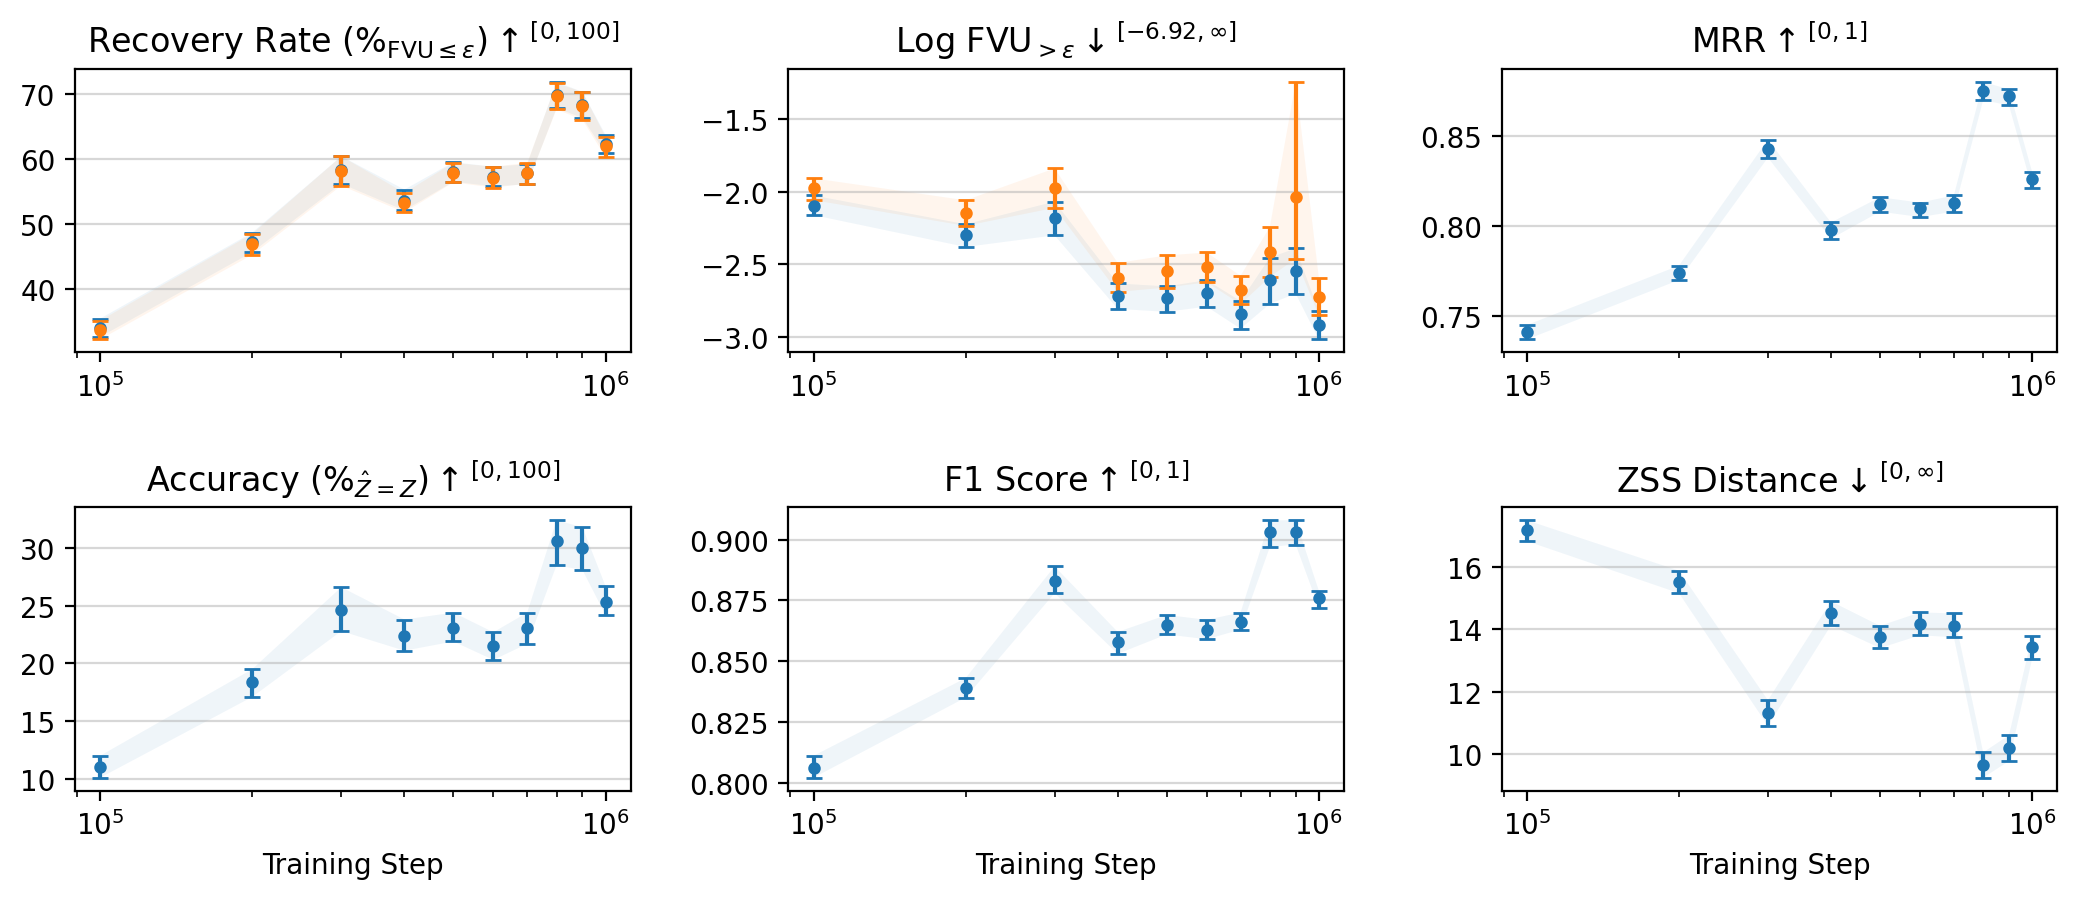

In [48]:
show_metric_list = ['FVU-eps_accuracy', 'log_fvu_not_epsilon', 'reciprocal_rank', 'accuracy_best_beam', 'f1_score_best_beam', 'tree_edit_distance_best_beam']
objective_list = ['max', 'min', 'max', 'max', 'max', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Log FVU$_{>\\epsilon}$', 'MRR', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'F1 Score', 'ZSS Distance']
bounds_list = [(0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, 1), (0, 100), (0, 1), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 1, 1, 100, 1, 1]
yscale_list = ['linear', 'linear', 'linear', 'linear', 'linear', 'linear']
# ylim_list = [(0, 100), (np.log10(np.finfo(np.float32).eps), None), (0, None), (0, 1), (0, None)]
ylim_list = [None, (None, None), None, None, None, None]

x = [int(model.split('/')[1].split('-')[1]) for model in MODELS]

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.5, ROWS * 2.3), dpi=200)

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, objective, bounds, yscale) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, objective_list, bounds_list, yscale_list)):

    show_metrics = [show_metric]
    if f'{show_metric}_val' in total_summary_tables[sub_metric]['median'].T.index:
        show_metrics.append(f'{show_metric}_val')

    for k, (s, label) in enumerate(zip(show_metrics, ['Fit', 'Validation'])):
        y = total_summary_tables[sub_metric]['median'].T.loc[s] * factor
        y_lower = total_summary_tables[sub_metric]['lower'].T.loc[s] * factor
        y_upper = total_summary_tables[sub_metric]['upper'].T.loc[s] * factor

        ax.errorbar(x, y, yerr=[y - y_lower, y_upper - y], fmt='.', markersize=7, capsize=3)
        sorted_indices = np.argsort(x)
        ax.fill_between(np.array(x)[sorted_indices], np.array(y_lower)[sorted_indices], np.array(y_upper)[sorted_indices], alpha=0.07)

    ax.set_xscale('log', base=10)
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    # ax.set_xticks(x)
    # ax.set_xticklabels(x, fontsize=9)

    if i // COLS == ROWS - 1:
        ax.set_xlabel('Training Step')
    # ax.set_xlabel('Beam Width')
    ax.grid(alpha=0.5, axis='y', which='both')

    ax.set_yscale(yscale)

    # if i == 2:
    #     ax.set_yticks(np.linspace(0, 1, 11).tolist())
    #     ax.set_yticklabels([f'A' for i in range(11)])

    ax.set_ylim(ylim)

    # if i == 1:
    #     # Annotate the first data point above the axis
    #     annotation = total_summary_tables[sub_metric]["median"].T.loc[show_metrics[0]]['analysis_points_v7.0/v7.0_1-points']
    #     ax.annotate(f'{annotation:.2f}', xy=(1, 0), xytext=(10, 1), textcoords='offset points', ha='right', va='bottom', color='tab:blue', fontsize=6)
        
    #     annotation = total_summary_tables[sub_metric]["median"].T.loc[show_metrics[1]]['analysis_points_v7.0/v7.0_1-points']
    #     ax.annotate(f'{annotation:.2f}', xy=(1, 0), xytext=(10, 8), textcoords='offset points', ha='right', va='bottom', color='tab:orange', fontsize=6)

for ax in axes.flatten()[len(show_metric_list):]:
    ax.axis('off')

fig.tight_layout(w_pad=2, h_pad=2)

plt.savefig(get_path('results', 'analysis_checkpoints', create=True, filename='analysis_checkpoints_errorbars.svg'))

In [47]:
sorted_models = sorted(MODELS, key=lambda x: int(x.split('/')[1].split('-')[1]))
sorted_models

['analysis_checkpoints_v7.0/v7.0_checkpoint-100000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-200000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-300000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-400000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-500000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-600000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-700000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-800000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-900000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-1000000']